# Úkol č. 3 - Segmentace zákazníků e-shopu (do 1. května)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


## Vypracování

Prozkoumání dat, co se týče země původu zákazníka.

In [4]:
clust = df[['Customer ID', 'Country']]
clust = clust.groupby('Country')['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)
print(clust.head())

zakaznici_CR = clust['Customer ID'].iat[0]
zakazniku_celkem = sum(clust['Customer ID'])

podil_CR = zakaznici_CR/zakazniku_celkem
print('Podil zakazniku z Ceske republiky: ', round(podil_CR*100), '%')

           Country  Customer ID
9   Czech Republic        21733
34        Slovakia          559
1        Australia           29
41  United Kingdom           21
15         Germany            4
Podil zakazniku z Ceske republiky:  97.0 %


97 % zákazníků na e-shopu je z České repuliky. Budeme tedy dále počítat pouze s nimi a ostatní vyřadíme.

In [5]:
df_CR = df.query("Country == 'Czech Republic'").reset_index(drop=True)
df_CR.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,61,7/14/2007,7.0,Czech Republic
3,78,7/21/2007,55.5,Czech Republic
4,79,7/21/2007,31.7,Czech Republic


Kontrola chybejicich hodnot.

In [6]:
df_CR.isnull().sum()

Customer ID    0
Date           0
Subtotal       0
Country        0
dtype: int64

Zjištění datumu poslední transakce, ke kterému budeme vztahovat všechna data ve sloupci "Recency".

In [7]:
import datetime as dt

#převod sloupce na typ datetime
df_CR['Date'] = pd.to_datetime(df_CR['Date'])

celkove_posledni_transakce = df_CR.Date.max()
celkove_posledni_transakce

Timestamp('2015-12-19 00:00:00')

#### Tvorba rfm dataframe. Pro každého zákazníka s Customer_ID jsou získány hodnoty:
- Recency (počet dnů od posledního nákupu zákazníka k dni poslední transakce na eshopu)
- Frequency (počet nákupů zákazníka s konkrétním ID celkem)
- Monetary (celková suma peněz utracená zákazníkem na eshopu)

In [8]:
rfm = pd.DataFrame(columns = ['Recency','Frequency','Monetary'])
grouped = df_CR.groupby('Customer ID')
for ID, df_zakaznik in grouped:
    posledni_nakup_zakaznika = df_zakaznik.Date.max()
    recency = (celkove_posledni_transakce - posledni_nakup_zakaznika).days
    frequency = len(df_zakaznik)
    monetary = df_zakaznik.Subtotal.sum()
    rfm.at[ID] = [recency, frequency, monetary]  
#převod na numerický datový typ
for column in rfm.columns:
    rfm[column] = pd.to_numeric(rfm[column])
rfm.index.name = 'Customer_ID'

In [9]:
# rfm.describe()

### Pro zajímavost: Scoring rfm dataframu a tvorba loyalty labels

 https://www.putler.com/rfm-analysis/

> "Take your customer data, give a score from 1-5 to R, F and M values. Using **quintiles** works best since it works for all businesses and adjusts according to your data."

https://www.youtube.com/watch?v=VE0m2FLoJCk

Vytvoření slovníku s hodnotami oddělujícími data na 5 rovných částí => 4 kvintily.

In [10]:
quantiles = rfm.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.2: 346.0, 0.4: 790.0, 0.6: 1257.0, 0.8: 1759.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'Monetary': {0.2: 28.59, 0.4: 51.03, 0.6: 90.34, 0.8: 181.65}}

Funkce na skórování dat podle toho, ve kterém kvintilu se datový bod nachází. Přiřazení hodnot 1 až 5.

In [11]:
# recency - čím nižší (méně dní od posledního nákupu), tím lépe => 5 nejmenší čísla, 1 nejvyšší 
def Score_R(buňka_sloupce, slovník, název_sloupce):
    '''např. quantiles['Recency'][0.2]'''
    if buňka_sloupce <= slovník[název_sloupce][0.2]:
        return 5
    elif buňka_sloupce <= slovník[název_sloupce][0.4]:
        return 4
    elif buňka_sloupce <= slovník[název_sloupce][0.6]:
        return 3
    elif buňka_sloupce <= slovník[název_sloupce][0.8]:
        return 2
    else:
        return 1

In [12]:
# frequency a monetary - čím vyšší, tím lépe => 5 nejvyšší, 1 nejnižší
def Score_F_or_M(buňka_sloupce, slovník, název_sloupce):
    if buňka_sloupce <= slovník[název_sloupce][0.2]:
        return 1
    elif buňka_sloupce <= slovník[název_sloupce][0.4]:
        return 2
    elif buňka_sloupce <= slovník[název_sloupce][0.6]:
        return 3
    elif buňka_sloupce <= slovník[název_sloupce][0.8]:
        return 4
    else:
        return 5

Aplikace funkcí, vytvoření nových sloupců v dataframu rfm:
- R, F, M (s hodnotou skóre 1 až 5)
- rfm_group - seskupení R, F a M
- rfm_score - výpočet score zákazníka (průměr hodnot R, F a M)

In [13]:
rfm['R'] = rfm['Recency'].apply(Score_R, args=(quantiles, 'Recency'))
rfm['F'] = rfm['Frequency'].apply(Score_F_or_M, args=(quantiles, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(Score_F_or_M, args=(quantiles, 'Monetary'))

rfm['rfm_group'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm['rfm_score'] = ((rfm.R + rfm.F + rfm.M)/3).round(1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score
Customer_ID,,,,,,,,
7,311,3,15.54,5,5,1,551,3.7
9,3050,1,13.20,1,1,1,111,1.0
30,3025,1,36.20,1,1,2,112,1.3
34,3103,1,86.00,1,1,3,113,1.7
38,3097,1,38.40,1,1,2,112,1.3


Přiřazení loyalty levelu zákazníkovi, na základě hodnoty rfm_score.

In [14]:
levels = ['Bronze','Silver', 'Gold', 'Platinum']
score_cuts = pd.qcut(rfm.rfm_score, q = 4, labels = levels)
rfm['loyalty_level'] = score_cuts.values
# rfm[rfm.rfm_group == '111'].sort_values('Monetary', ascending=False)

In [15]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level
Customer_ID,,,,,,,,,
7,311,3,15.54,5,5,1,551,3.7,Platinum
9,3050,1,13.20,1,1,1,111,1.0,Bronze
30,3025,1,36.20,1,1,2,112,1.3,Bronze
34,3103,1,86.00,1,1,3,113,1.7,Bronze
38,3097,1,38.40,1,1,2,112,1.3,Bronze


Vytvoření mapperů, pomocí kterých přiřadíme zákazníky do clusterů na základě jejich loyalty levelu.

In [16]:
mappers = {level:number for level,number in zip(rfm.loyalty_level.unique(), range(4))}
mappers

{'Platinum': 0, 'Bronze': 1, 'Gold': 2, 'Silver': 3}

In [17]:
rfm['loyalty_cluster'] = rfm.loyalty_level.map(mappers)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level,loyalty_cluster
Customer_ID,,,,,,,,,,
7,311,3,15.54,5,5,1,551,3.7,Platinum,0
9,3050,1,13.20,1,1,1,111,1.0,Bronze,1
30,3025,1,36.20,1,1,2,112,1.3,Bronze,1
34,3103,1,86.00,1,1,3,113,1.7,Bronze,1
38,3097,1,38.40,1,1,2,112,1.3,Bronze,1


# Příprava na vizualizaci: tvorba funkcí na "plotění"
něco málo o gridspec (tvorba custom mřížky plotu - moc pěkný): https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html

In [18]:
import seaborn as sns
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

Funkce, která vytvoří 3d plot a 2d projekce do všech třech os. Zadávám dataset, seznam, podle kterého se budou obarvovat shluky a seznam, podle kterého se budou zobrazovat středy shluků. U posledních dvou argumentů je možno předat "None", pokud shluky netvoříme, nebo nechceme zobrazit středy.

In [19]:
def plot_2d_3d(dataset, cluster_colors,cluster_centers):
    '''cluster_colors a cluster_centers: None nebo seznam podle kterého má dělat barvy shluků'''
    
    x = ['Recency', dataset.Recency]
    y = ['Frequency', dataset.Frequency]
    z = ['Monetary', dataset.Monetary]
    
    # tvorba figure a rozmístění axes do mřížky vytvořené pomocí gridspec
    fig = plt.figure(figsize=[15,7])
    gs = fig.add_gridspec(3,5)
    ax1 = fig.add_subplot(gs[0,:2])
    ax2 = fig.add_subplot(gs[1,:2])
    ax3 = fig.add_subplot(gs[2,:2])
    ax4 = fig.add_subplot(gs[0:,2:], projection='3d')
    
    # 2d kombinace [R,F], [R,M], [M,D] a pak 3d plot všech tří
    axes = {ax1:[x,y], ax2:[x,z], ax3:[z,y], ax4:[x,y,z]}
    
    for name, data in axes.items():
        if len(data)<=2:
            # dvourozměrné ploty
            name.scatter(data[0][1], data[1][1], c=cluster_colors, cmap='brg', alpha=0.3)
            name.set_xlabel(data[0][0])
            name.set_ylabel(data[1][0])
            # středy shluků
            if type(cluster_centers) != type(None):
                cluster_centers = pd.DataFrame(kmeans.cluster_centers_,columns=['Recency','Frequency','Monetary'])
                # jména sloupců
                a, b = data[0][0], data[1][0]
                name.scatter(cluster_centers[a], cluster_centers[b],c = 'black', s=100, alpha=1)      
        else:
            # 3D plot
            name.scatter(data[0][1], data[1][1], data[2][1], c=cluster_colors, cmap='brg',alpha=0.1)
            name.set_xlabel(data[0][0])
            name.set_ylabel(data[1][0])
            name.set_zlabel(data[2][0])
            # středy shluků
            if type(cluster_centers) != type(None):
                cluster_centers = pd.DataFrame(kmeans.cluster_centers_,columns=['Recency','Frequency','Monetary'])
                # jména sloupců
                a, b, c = data[0][0], data[1][0], data[2][0]
                name.scatter(cluster_centers[a], cluster_centers[b],cluster_centers[c],c = 'black', s=100, alpha=1)
    plt.show()

# První pokus o vizualizaci dat

### Vizualizace podle loyalty label (pro zajímavost - nesouvisí s k-means)

In [20]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level,loyalty_cluster
Customer_ID,,,,,,,,,,
7,311,3,15.54,5,5,1,551,3.7,Platinum,0
9,3050,1,13.20,1,1,1,111,1.0,Bronze,1
30,3025,1,36.20,1,1,2,112,1.3,Bronze,1
34,3103,1,86.00,1,1,3,113,1.7,Bronze,1
38,3097,1,38.40,1,1,2,112,1.3,Bronze,1


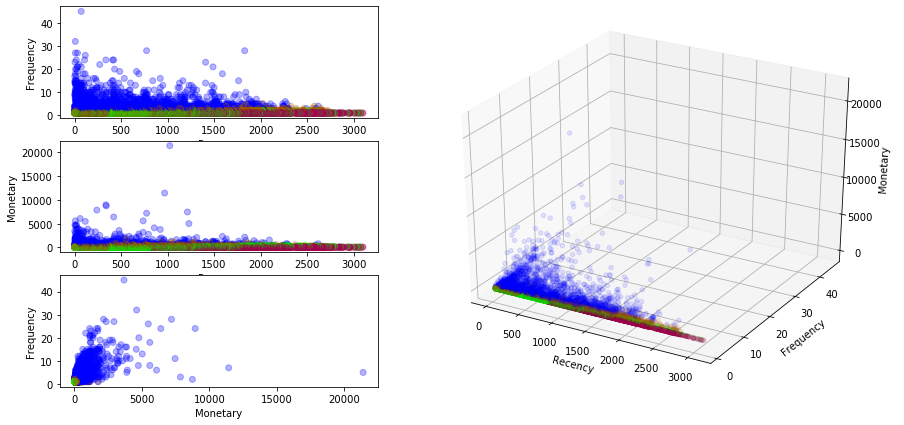

In [21]:
plot_2d_3d(rfm, cluster_colors=rfm.loyalty_cluster,cluster_centers=None)

### Zkouška k-means bez přeškálování

inertia_: Sum of squared distances of samples to their closest cluster center. (sklearn documentation)

Pomocí velikostí sum čtverců vzdáleností bodů od nejbližšího středu shluku určím, jaký počet shluků je nejvhodnější. Hledám zlom v grafu pro různá k.

In [22]:
from sklearn.cluster import KMeans
sum_of_sq_dist = {}
# počítám sumu čtverců vzdáleností pro různé počty klastrů (2 až 14)
for k in range(1,15):
    kmeans = KMeans(n_clusters= k, max_iter= 1000, random_state = 1)
    kmeans = kmeans.fit(rfm[['Recency','Frequency','Monetary']])
    sum_of_sq_dist[k] = kmeans.inertia_

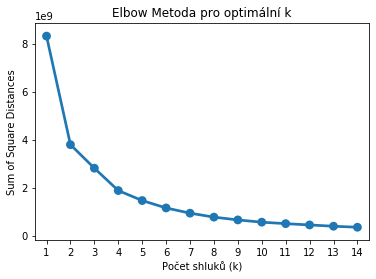

In [23]:
# Plotím graf sum of square distances a počtu klastrů
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Počet shluků (k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Metoda pro optimální k')
plt.show()

Provedeme k-means clustering pro vhodný počet shluků určený pomocí Elbow metody.

Vhodný počet shluků určíme tak, že se díváme na velikost poklesu hodnot funkce na ose y. Ve chvíli, kdy rozdíl začíná být zanedbatelný, tam se zastavíme. V tomto případě jsem tedy zvolila počet shluků k = 4.

In [24]:
kmeans = KMeans(n_clusters= 4, max_iter= 1000, random_state = 1)
kmeans = kmeans.fit(rfm[['Recency','Frequency','Monetary']])

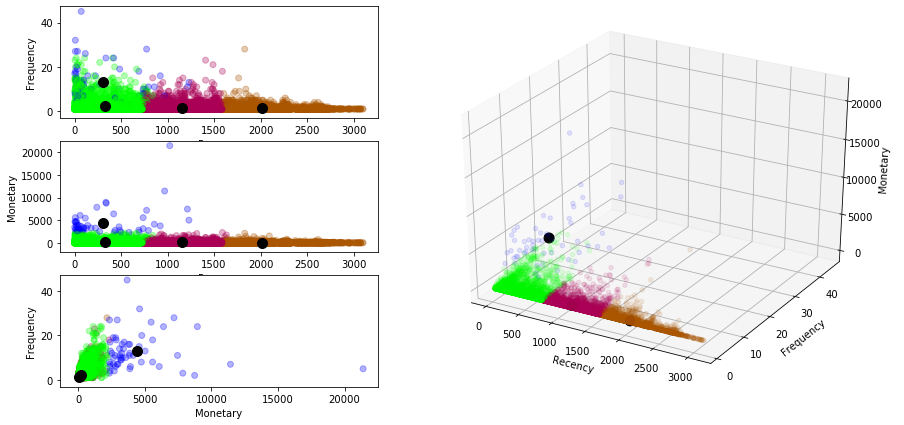

In [25]:
plot_2d_3d(rfm, cluster_colors=kmeans.labels_,cluster_centers=kmeans.cluster_centers_)

Podíváme se na rozdělení hodnot jednotlivých příznaků (recency, frequency a monetary). Zajímá nás, zda mají rozdělení blízké normálnímu.

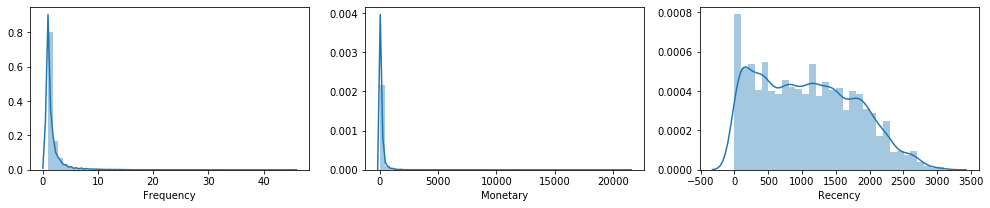

In [26]:
fig = plt.figure(figsize=[17,3])
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

frequency_plot = rfm.Frequency
monetary_plot = rfm.Monetary
recency_plot = rfm.Recency

sns.distplot(frequency_plot, ax=ax1)
sns.distplot(monetary_plot, ax=ax2)
sns.distplot(recency_plot, ax=ax3)

plt.show()

Abychom mohli pozorovat rozumné rozdíly v datech, bude třeba je přeškálovat.

### Přeškálování
video: https://www.youtube.com/watch?v=JCV7pPxJDdk

In [27]:
s_rfm = rfm[['Recency', 'Frequency', 'Monetary']].copy(deep=True)
# s_rfm.describe()

Pokus o převod na rozdělení blízké normálnímu. Logaritmuji pouze *Monetary* a *Frequency*. Zkoušela jsem logaritmovat i *Recency*, ale rozdělení se zleva zešikmilo, tak jsem se rozhodla nechat jeho původní stav.

In [28]:
s_rfm.Monetary = np.log1p(s_rfm.Monetary)
s_rfm.Frequency = np.log1p(s_rfm.Frequency)
# s_rfm.describe()

Standardizace příznaků pomocí StandardScaler(), které převede vstupní rozdělení na rozdělení s průměrem nula a směrodatnou odchylkou 1.

In [29]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
fit = scaling.fit_transform(s_rfm)
s_rfm = pd.DataFrame(fit, columns = s_rfm.columns)
# s_rfm.describe()

Vizualizace rozdělení dat po logaritmování a standardizaci.

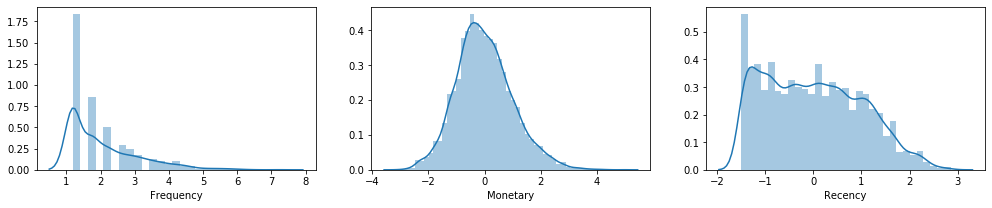

In [30]:
fig = plt.figure(figsize=[17,3])
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

frequency_plot = s_rfm.query('Frequency > 1')['Frequency']
monetary_plot = s_rfm.Monetary
recency_plot = s_rfm.Recency

sns.distplot(frequency_plot, ax=ax1)
sns.distplot(monetary_plot, ax=ax2)
sns.distplot(recency_plot, ax=ax3)
plt.show()

U *frequency* se jedná stále o zprava zešikmené rozdělení, ale alespoň je rozdíl v hodnotách po zlogaritmování menší.

# Druhý pokus o vizualizaci dat (po přeškálování)

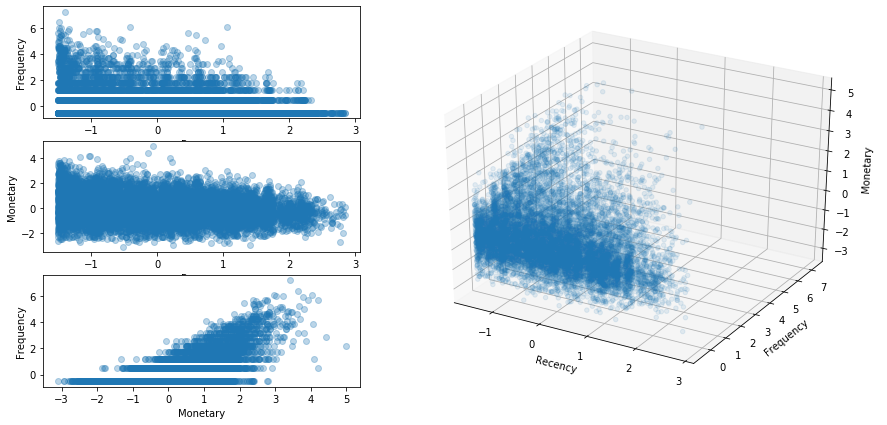

In [31]:
plot_2d_3d(s_rfm, cluster_colors=None, cluster_centers=None)

# K-means shlukování
video: https://www.youtube.com/watch?v=jBffqlNKMtI

### Elbow metoda určení počtu shluků na standardizovaných datech

In [32]:
from sklearn.cluster import KMeans
sum_of_sq_dist = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters= k, max_iter= 1000, random_state = 1)
    kmeans = kmeans.fit(s_rfm)
    sum_of_sq_dist[k] = kmeans.inertia_

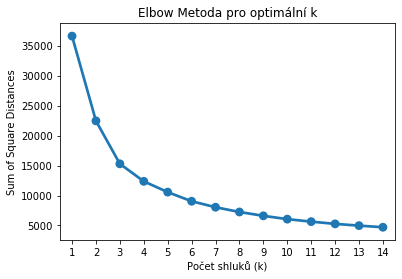

In [33]:
# Plotím graf sum of square distances a počtu klastrů
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Počet shluků (k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Metoda pro optimální k')
plt.show()

Volím počet shluků k=4.

In [34]:
kmeans = KMeans(n_clusters= 4, max_iter= 1000, random_state = 1)
kmeans = kmeans.fit(s_rfm)

Zároveň přidám labels shluků do datasetu rfm.

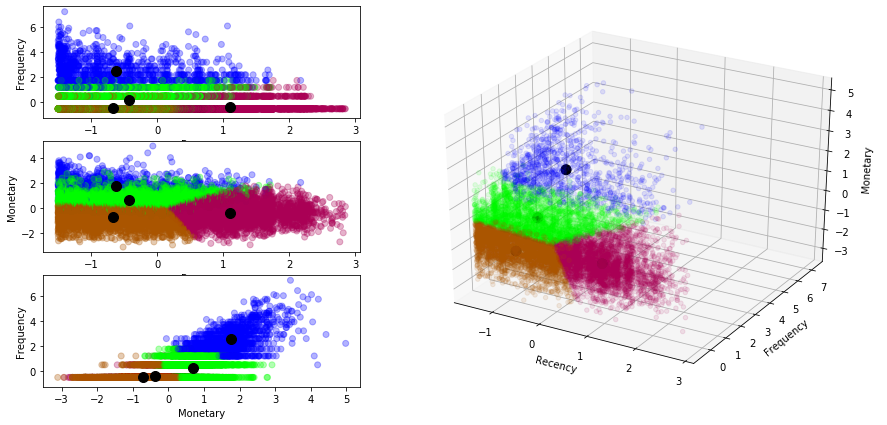

In [35]:
plot_2d_3d(s_rfm, cluster_colors=kmeans.labels_,cluster_centers=kmeans.cluster_centers_)
rfm['Elbow_method'] = kmeans.labels_

### Silhouette metoda určení počtu shluků

Alternativní metoda odhadu počtu shluků. Počet shluků se v tomto případě odhaduje na základě Silhouette koeficientu = (x-y)/ max(x,y), kde x je vzdálenost bodu od středu shluku, do kterého bod náleží a y je vzdálenost bodu od středu nejbližšího dalšího shluku. 

Zde počítám průměrné silhouette skóre (pro každý datový bod se spočte skóre, které může nabývat hodnot z intervalu -1 až 1, bereme průměr těchto skóre). Čím vyšší skóre získáme, tím lépe jsou datové body přiřazeny shlukům.

https://medium.com/@jyotiyadav99111/selecting-optimal-number-of-clusters-in-kmeans-algorithm-silhouette-score-c0d9ebb11308

In [36]:
from sklearn.metrics import silhouette_score

score_averages = {}
for n_clusters in range(2, 8):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(s_rfm)
    score_averages[n_clusters] = silhouette_score(s_rfm,cluster_labels)

In [37]:
score_averages

{2: 0.43049485984954844,
 3: 0.3540228865066477,
 4: 0.3269841529989247,
 5: 0.31984410649289835,
 6: 0.29162568507200987,
 7: 0.3047219559200958}

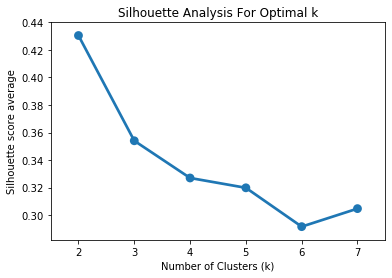

In [38]:
sns.pointplot(x = list(score_averages.keys()), y = list(score_averages.values()))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score average')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

Z výše uvedeného vyplývá, že nejlepší počet shluků určíme tak, že hledáme bod s nejvyšší hodnotou silhouette score. Volím tedy k=2.

In [39]:
kmeans = KMeans(n_clusters= 2, max_iter= 1000, random_state = 1)
kmeans = kmeans.fit(s_rfm)

Zároveň přidám labels shluků do datasetu rfm.

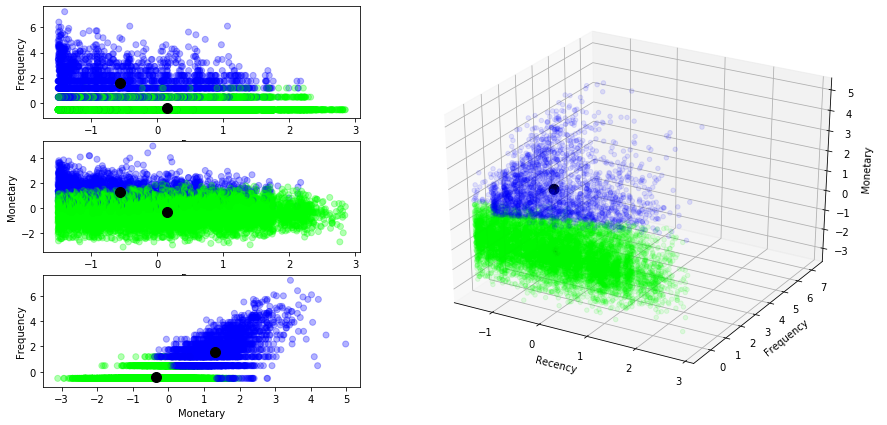

In [40]:
plot_2d_3d(s_rfm, cluster_colors=kmeans.labels_,cluster_centers=kmeans.cluster_centers_)
rfm['Silhouette_method'] = kmeans.labels_

# Odlišení superstar zákazníků

Nejdříve se podíváme na data seřazená sestupně podle Frequency a Monetary a vzestupně podle Recency. Pozornost směřujeme na poslední 3 sloupce týkající se klastrů vytvořených za pomocí skórování přes kvantily (loyalty level), pomocí Elbow metody a Silhouette metody určování počtu klastrů.

In [41]:
display(rfm.sort_values('Frequency', ascending=False).head())
display(rfm.sort_values('Monetary', ascending=False).head())
display(rfm.sort_values('Recency', ascending=True).head())

,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level,loyalty_cluster,Elbow_method,Silhouette_method
Customer_ID,,,,,,,,,,,,
582,72,45,3669.14,5,5,5,555,5.0,Platinum,0,0,0
2482,9,32,4605.18,5,5,5,555,5.0,Platinum,0,0,0
2074,1830,28,2154.51,1,5,5,155,3.7,Platinum,0,0,0
5291,775,28,7189.53,4,5,5,455,4.7,Platinum,0,0,0
2777,32,27,2345.95,5,5,5,555,5.0,Platinum,0,0,0


,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level,loyalty_cluster,Elbow_method,Silhouette_method
Customer_ID,,,,,,,,,,,,
4912,1024,5,21392.38,3,5,5,355,4.3,Platinum,0,0,0
6544,969,7,11427.92,3,5,5,355,4.3,Platinum,0,0,0
9639,337,24,8945.18,5,5,5,555,5.0,Platinum,0,0,0
13481,341,2,8739.21,5,4,5,545,4.7,Platinum,0,0,0
12294,240,3,7851.53,5,5,5,555,5.0,Platinum,0,0,0


,Recency,Frequency,Monetary,R,F,M,rfm_group,rfm_score,loyalty_level,loyalty_cluster,Elbow_method,Silhouette_method
Customer_ID,,,,,,,,,,,,
15360,0,1,139.10,5,1,4,514,3.3,Gold,2,3,1
15359,0,1,19.15,5,1,1,511,2.3,Silver,3,2,1
15358,1,1,153.23,5,1,4,514,3.3,Gold,2,3,1
15357,1,1,6.10,5,1,1,511,2.3,Silver,3,2,1
15356,1,1,31.87,5,1,2,512,2.7,Gold,2,2,1


Je vidět, že největší vliv má pravděpodobně Frequency a Monetary.

Ve všech třech sloupcích je předmětem našeho zájmu (superstar zákazníci - vysoká frequency a monetary, nízká recency) **shluk s číslem 0** (ve vizualizacích modře).

Počty superstar zákazníků se liší podle metody shlukování a také dle toho, kolik shluků jsme tvořili.

In [42]:
print("Počet superstar zákazníků (loyalty_label): ",rfm.loyalty_cluster[rfm.loyalty_cluster == 0].count())
print("Počet superstar zákazníků (Elbow_method): ",rfm.Elbow_method[rfm.Elbow_method == 0].count())
print("Počet superstar zákazníků (Silhouette_method): ",rfm.Silhouette_method[rfm.Silhouette_method == 0].count())

Počet superstar zákazníků (loyalty_label):  2932
Počet superstar zákazníků (Elbow_method):  1150
Počet superstar zákazníků (Silhouette_method):  2503


Pokud bychom chtěli najít ID zákazníků klasifikovaných jako superstar zákazníci (shluk s číslem nula), použili bychom následující kód. Příklad uvádím pro Silhouette metodu.

In [43]:
Superstar_customers_ID = list(rfm.index[rfm.Silhouette_method == 0])
# Superstar_customers_ID

Předpokládám, že cílem metody je právě nalezení této informace, po kterém bude následovat nějaká cílená akce zaměřená na tento typ zákazníků (reklama apod.)